In [1]:
%matplotlib inline
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
from tqdm import tqdm 
from PIL import Image
import torch
import torchvision
import os
import cv2

pylab.rcParams['figure.figsize'] = (8.0, 10.0)
wrkdir = '/home/arsalikhov/Documents/PSYCH420_final_project/'

In [2]:
classes = {
    "bird": 1,
    "cat": 2,
    "dog": 3,
    "horse": 4,
    "sheep": 5,
    "cow": 6,
    "elephant": 7,
    "bear": 8,
    "zebra": 9,
    "giraffe": 10
}


In [54]:
class myOwnDataset(torch.utils.data.Dataset):
    def __init__(self, root, annotation, ids, cat, labels, transforms=None):
        self.root = root
        self.transforms = transforms
        self.coco = COCO(annotation)
        self.ids = ids
        self.labels = labels
        self.cat = cat


    def __getitem__(self, index):
        # Own coco file
        coco = self.coco
        # Image ID
        img_id = self.ids[index]
        # List: get annotation id from coco
        ann_ids = coco.getAnnIds(imgIds=img_id, catIds=self.cat, iscrowd=None)
        # Dictionary: target coco_annotation file for an image
        coco_annotation = coco.loadAnns(ann_ids)
        # path for input image
        path = coco.loadImgs(img_id)[0]['file_name']
        # open the input image
        img = Image.open(os.path.join(self.root, path))
        # unmasked_img = np.array(unmasked_img)
        # #create_mask
        # mask = coco.annToMask(coco_annotation[0])
        # if len(unmasked_img.shape) == 2:
        #     img = unmasked_img*mask
        # else:
        #     mask = cv2.cvtColor(mask,cv2.COLOR_GRAY2RGB)
        #     img = unmasked_img*mask

        # img = Image.fromarray(img)
        # number of objects in the image
        num_objs = len(coco_annotation)

        # Bounding boxes for objects
        # In coco format, bbox = [xmin, ymin, width, height]
        # In pytorch, the input should be [xmin, ymin, xmax, ymax]
        boxes = []
        for i in range(num_objs):
            xmin = coco_annotation[i]['bbox'][0]
            ymin = coco_annotation[i]['bbox'][1]
            xmax = xmin + coco_annotation[i]['bbox'][2]
            ymax = ymin + coco_annotation[i]['bbox'][3]
            boxes.append([xmin, ymin, xmax, ymax])
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # Labels (In my case, I only one class: target class or background)
        labels = torch.as_tensor(np.full(num_objs, self.labels), dtype=torch.int64)
        # Tensorise img_id
        img_id = torch.tensor([img_id])
        # Size of bbox (Rectangular)
        areas = []
        for i in range(num_objs):
            areas.append(coco_annotation[i]['area'])
        areas = torch.as_tensor(areas, dtype = torch.float32)
        # Iscrowd
        iscrowd = torch.zeros((num_objs,), dtype = torch.int64)

        # Annotation is in dictionary format
        my_annotation = {}
        my_annotation["boxes"] = boxes
        my_annotation["labels"] = labels
        my_annotation["image_id"] = img_id
        my_annotation["area"] = areas
        my_annotation["iscrowd"] = iscrowd

        if self.transforms is not None:
            img = self.transforms(img)

    

        return img, my_annotation

    def __len__(self):
        return len(self.ids)

In [61]:
dataDir='/media/gamedisk/COCO_dataset/'
dataType='val2017'

annFile='{}/annotations/instances_{}.json'.format(dataDir,dataType)

def get_transform():
    custom_transforms = []
    custom_transforms.append(torchvision.transforms.Resize((256, 256)))
    custom_transforms.append(torchvision.transforms.ToTensor())
    return torchvision.transforms.Compose(custom_transforms)

# collate_fn needs for batch
def collate_fn(batch):
    return tuple(zip(*batch))

# Batch size
train_batch_size = 1

In [62]:
coco = COCO(annFile)

loading annotations into memory...
Done (t=0.21s)
creating index...
index created!


In [63]:
def concat_datasets(dataDir, dataType, annFile):
    sub_class_sets = []
    for key, value in classes.items():
        ids = coco.getCatIds(catNms=[key])
        imgIds = coco.getImgIds(catIds=ids)
        if value == 0:
            print(key, value, ids, imgIds[0])
        interim = myOwnDataset(root= dataDir + 'images/'+ dataType,
                            annotation=annFile,
                            ids = imgIds,
                            cat = ids,
                            labels = value,
                            transforms=get_transform())
        # interim_data_loader = torch.utils.data.DataLoader(interim,
        #                                   batch_size=train_batch_size,
        #                                   shuffle=True,
        #                                   num_workers=4,
        #                                   collate_fn = collate_fn)
        sub_class_sets.append(interim)
    data_sets = torch.utils.data.ConcatDataset(sub_class_sets)
    data_loader =  torch.utils.data.DataLoader(data_sets,
                                            batch_size=train_batch_size,
                                            shuffle=True,
                                            num_workers=4,
                                            collate_fn = collate_fn)

    return data_loader

data_loader = concat_datasets(dataDir, dataType, annFile)


loading annotations into memory...
Done (t=0.21s)
creating index...
index created!
loading annotations into memory...
Done (t=0.22s)
creating index...
index created!
loading annotations into memory...
Done (t=0.21s)
creating index...
index created!
loading annotations into memory...
Done (t=1.53s)
creating index...
index created!
loading annotations into memory...
Done (t=0.21s)
creating index...
index created!
loading annotations into memory...
Done (t=0.21s)
creating index...
index created!
loading annotations into memory...
Done (t=0.21s)
creating index...
index created!
loading annotations into memory...
Done (t=0.21s)
creating index...
index created!
loading annotations into memory...
Done (t=0.20s)
creating index...
index created!
loading annotations into memory...
Done (t=0.20s)
creating index...
index created!


In [64]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
images = []

for imgs, annotations in data_loader:
    images.append(list(img for img in imgs))
    imgs = list(img for img in imgs)
    annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]

torch.Size([256, 256, 3])

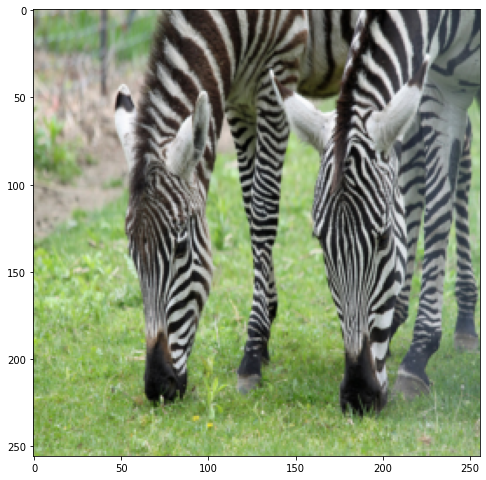

In [73]:
image = images[960][0].permute(1, 2, 0)
plt.imshow(image.numpy())
image.shape


In [20]:
for h, img in enumerate(images):
    print(img)

[torch.Size([3, 480, 480])]
[torch.Size([3, 480, 480])]
[torch.Size([3, 480, 480])]
[torch.Size([3, 480, 480])]
[torch.Size([3, 480, 480])]
[torch.Size([3, 480, 480])]
[torch.Size([3, 480, 480])]
[torch.Size([3, 480, 480])]
[torch.Size([3, 480, 480])]
[torch.Size([3, 480, 480])]
[torch.Size([3, 480, 480])]
[torch.Size([3, 480, 480])]
[torch.Size([3, 480, 480])]
[torch.Size([3, 480, 480])]
[torch.Size([3, 480, 480])]
[torch.Size([3, 480, 480])]
[torch.Size([3, 480, 480])]
[torch.Size([3, 480, 480])]
[torch.Size([3, 480, 480])]
[torch.Size([3, 480, 480])]
[torch.Size([3, 480, 480])]
[torch.Size([3, 480, 480])]
[torch.Size([3, 480, 480])]
[torch.Size([3, 480, 480])]
[torch.Size([3, 480, 480])]
[torch.Size([3, 480, 480])]
[torch.Size([3, 480, 480])]
[torch.Size([3, 480, 480])]
[torch.Size([3, 480, 480])]
[torch.Size([3, 480, 480])]
[torch.Size([3, 480, 480])]
[torch.Size([3, 480, 480])]
[torch.Size([3, 480, 480])]
[torch.Size([3, 480, 480])]
[torch.Size([3, 480, 480])]
[torch.Size([3, 480,